# Feature Selection



## Basic Filters

- Remove constant features
- Remove quasi-constant features
- Select K Best
- Select Percentile


In [ ]:
# Example of Select K Best
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2

X, y = load_iris(return_X_y=True)
print(X.shape)

# select the two best features - HOW DO YOU DECIDE K=2???
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
print(X_new.shape)

(150, 4)
(150, 2)


In [ ]:
# Example of Select Percentile
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2
X, y = load_digits(return_X_y=True)
print(X.shape)

# now select features based on top 10 percentile
X_new = SelectPercentile(chi2, percentile=10).fit_transform(X, y)
print(X_new.shape)

(1797, 64)
(1797, 7)


## Mutual Information Filtering

(Sometimes called Information Gain)

In feature engineering, a great first step is to construct a ranking with a **feature utility metric**, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect *any* kind of relationship, while correlation only detects *linear* relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:
- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship



### Mutual Information and What it Measures

Mutual information describes relationships in terms of *uncertainty*. The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of one feature, how much more confident would you be about the target? X.A -> y

Here's an example from the *Ames Housing* data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

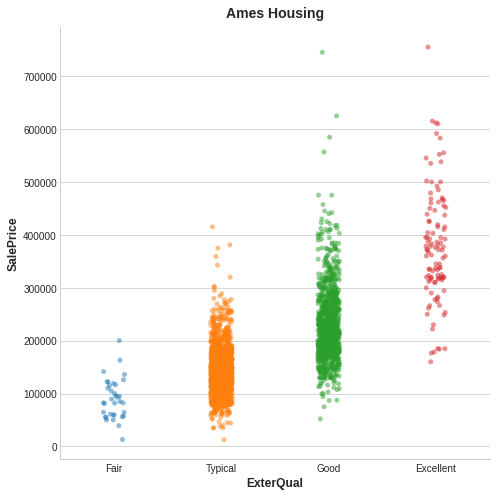

From the figure, we can see that knowing the value of `ExterQual` should make you more certain about the corresponding `SalePrice` -- each category of `ExterQual` tends to concentrate `SalePrice` to within a certain range. The mutual information that `ExterQual` has with `SalePrice` is the average reduction of uncertainty in `SalePrice` taken over the four values of `ExterQual`. Since `Fair` occurs less often than `Typical`, for instance, `Fair` gets less weight in the MI score.

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

Here are some things to remember when applying mutual information:
- MI can help you to understand the *relative potential* of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI *can't detect interactions* between features. It is a **univariate** metric.
- The *actual* usefulness of a feature *depends on the model you use it with*. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

 ### Example: 1985 Automobiles

The [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv(f"{root_path}/data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that *must* have a `float` dtype is *not* discrete. Categoricals (`object` or `categorial` dtype) can be treated as discrete by giving them a label encoding.

In [ ]:
X = df.copy()
y = X.pop("price")

# {"Male": 0, "Female": 1, "Other": 2}
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes
discrete_features = X.dtypes == int

Scikit-learn has two mutual information metrics in its `feature_selection` module: one for real-valued targets (`mutual_info_regression`) and one for categorical targets (`mutual_info_classif`). Our target, `price`, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          1.499552
highway_mpg          0.956623
length               0.617589
bore                 0.486480
stroke               0.394535
num_of_cylinders     0.330240
compression_ratio    0.135194
fuel_type            0.047298
Name: MI Scores, dtype: float64

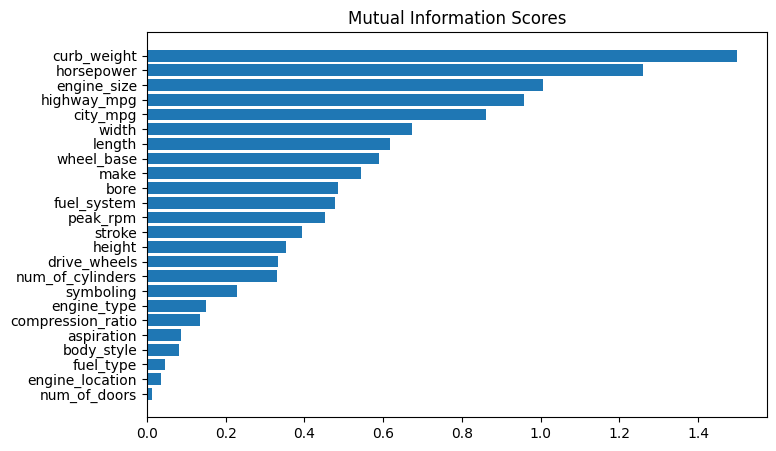

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with `price`, the target.


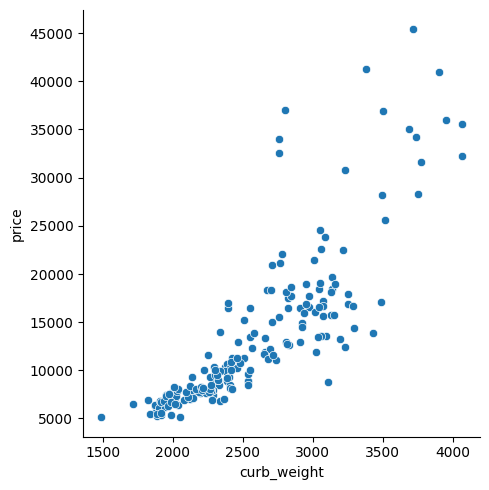

In [ ]:
sns.relplot(x="curb_weight", y="price", data=df);

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an **interaction effect** and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- **domain knowledge can offer a lot of guidance here.**

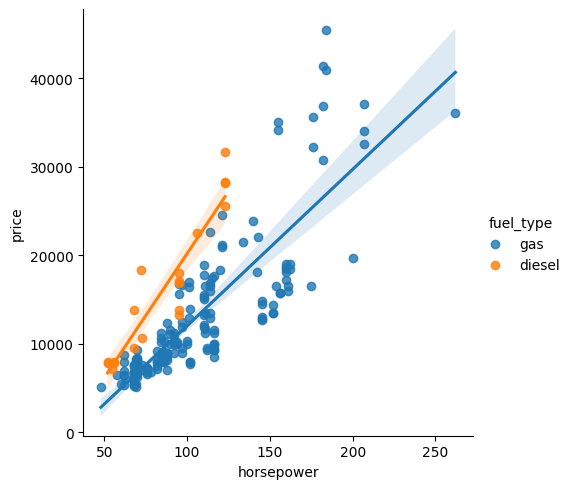

In [ ]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

## Recursive Feature Elimination

It is a greedy optimization algorithm which aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are exhausted. It then ranks the features based on the order of their elimination.

Recursive feature elimination performs a greedy search to find the best performing feature subset. It iteratively creates models and determines the best or the worst performing feature at each iteration. It constructs the subsequent models with the left features until all the features are explored. It then ranks the features based on the order of their elimination. In the worst case, if a dataset contains N number of features RFE will do a greedy search for 2N combinations of features.

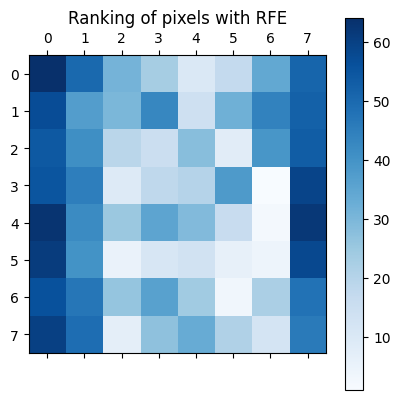

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

## Random Forest Importance

- Random forests are one the most popular machine learning algorithms. They are so successful because they provide in general a good predictive performance, low overfitting and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.

- Random forests consist of hundreds of decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each leaf (this is at each question), the tree divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived by how "pure" each of the buckets is.

In [ ]:
# Import libraries
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load dataset
df = pd.read_csv(f"{root_path}/data/mushrooms.csv")

In [ ]:
# Declare feature vector and target variable
X = df.drop(['class'], axis = 1)
y = df['class']

In [ ]:
# Encode categorical variables
X = pd.get_dummies(X, prefix_sep='_')
y = LabelEncoder().fit_transform(y)

In [ ]:
# Normalize feature vector
X2 = StandardScaler().fit_transform(X)

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.30, random_state = 0)

In [ ]:
# instantiate the classifier with n_estimators = 100
clf = RandomForestClassifier(n_estimators=100, random_state=0)

In [ ]:
# fit the classifier to the training set
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
# predict on the test set
y_pred = clf.predict(X_test)

<Axes: >

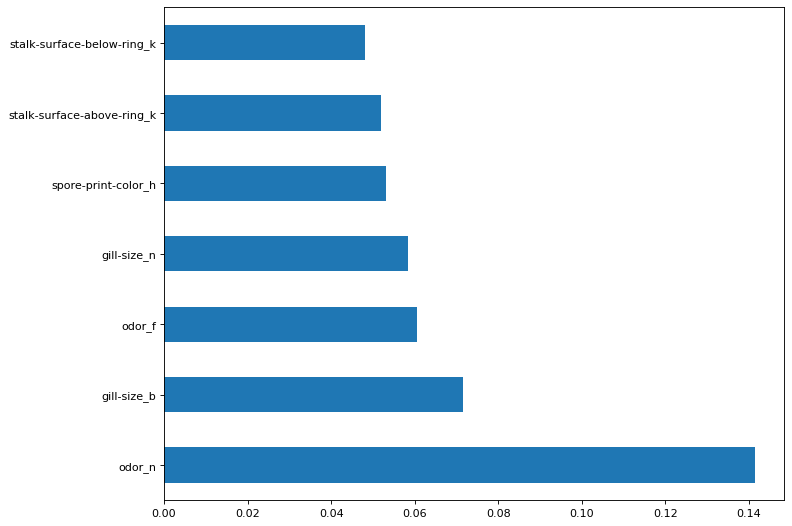

In [ ]:
# visualize feature importance

plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(clf.feature_importances_, index= X.columns)
feat_importances.nlargest(7).plot(kind='barh')

# Feature Engineering


## The Goal of Feature Engineering

The goal of feature engineering is simply to make your data better suited to the problem at hand.

Consider "feels like temperature" measures like the heat index and the wind chill. These quantities attempt to measure the *perceived* temperature to humans based on air temperature, humidity, and wind speed, things which we can measure directly. You could think of an feels like temperature as the result of a kind of feature engineering, an attempt to make the observed data more relevant to what we actually care about: how it actually feels outside!

You might perform feature engineering to:
- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

## A Guiding Principle of Feature Engineering

For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear models, for instance, are only able to learn linear relationships. So, when using a linear model, your goal is to transform the features to make their relationship to the target linear.

The key idea here is that a transformation you apply to a feature becomes in essence a part of the model itself. Say you were trying to predict the `Price` of square plots of land from the `Length` of one side. Fitting a linear model directly to `Length` gives poor results: the relationship is not linear.

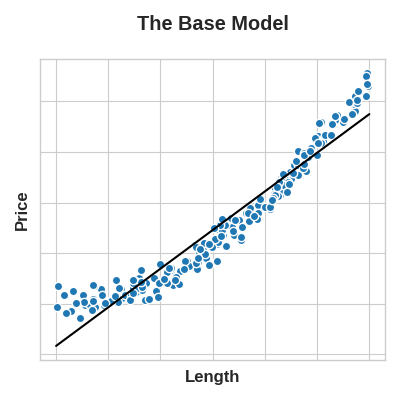

If we square the `Length` feature to get `'Area'`, however, we create a linear relationship. Adding `Area` to the feature set means this linear model can now fit a parabola. Squaring a feature, in other words, gave the linear model the ability to fit squared features.

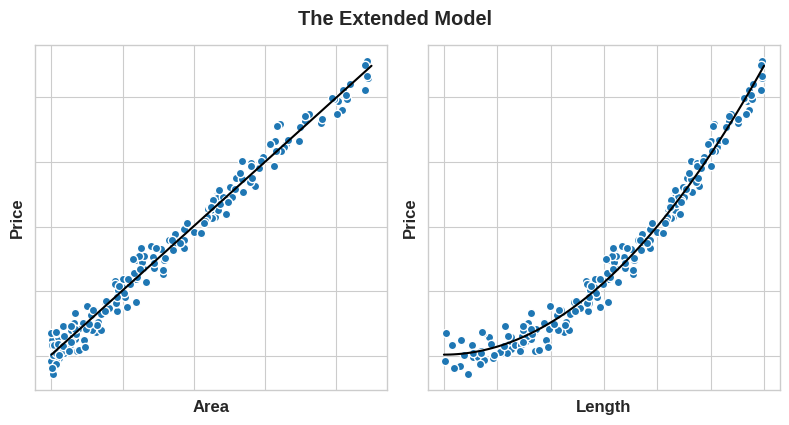

This should show you why there can be such a high return on time invested in feature engineering. **Whatever relationships your model can't learn, you can provide yourself through transformations.** As you develop your feature set, think about what information your model could use to achieve its best performance.

### Example: Concrete Formulations

To illustrate these ideas we'll see how adding a few synthetic features to a dataset can improve the predictive performance of a random forest model.

The [*Concrete*](https://www.kaggle.com/sinamhd9/concrete-comprehensive-strength) dataset contains a variety of concrete formulations and the resulting product's *compressive strength*, which is a measure of how much load that kind of concrete can bear. The task for this dataset is to predict a concrete's compressive strength given its formulation.


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv(f"{root_path}/data/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"Mean Absolute Error Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


If you ever cook at home, you might know that the *ratio* of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of `CompressiveStrength`.

In [ ]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"Mean Absolute Error Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


And sure enough, performance improved! This is evidence that these new ratio features exposed important information to the model that it wasn't detecting before.


We've seen that engineering new features can improve model performance.  But how do you identify features in the dataset that might be useful to combine?

## Principal Component Analysis

Principal component analysis (PCA): You could think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

In the [*Abalone*](https://www.kaggle.com/rodolfomendes/abalone-dataset) dataset are physical measurements taken from several thousand Tasmanian abalone. (An abalone is a sea creature much like a clam or an oyster.) We'll just look at a couple features for now: the `'Height'` and `'Diameter'` of their shells.

You could imagine that within this data are "axes of variation" that describe the ways the abalone tend to differ from one another. Pictorially, these axes appear as perpendicular lines running along the natural dimensions of the data, one axis for each original feature.

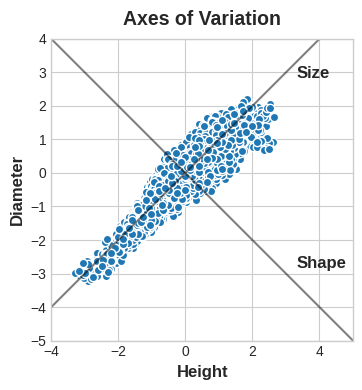

Often, we can give names to these axes of variation. The longer axis we might call the "Size" component: small height and small diameter (lower left) contrasted with large height and large diameter (upper right). The shorter axis we might call the "Shape" component: small height and large diameter (flat shape) contrasted with large height and small diameter (round shape).

Notice that instead of describing abalones by their `'Height'` and `'Diameter'`, we could just as well describe them by their `'Size'` and `'Shape'`. This, in fact, is the whole idea of PCA: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

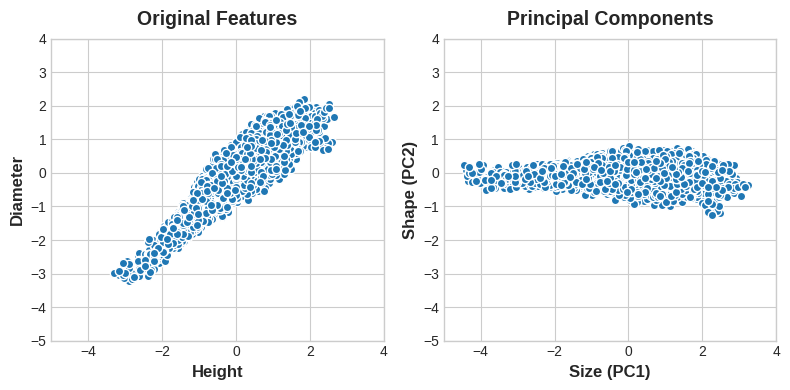


The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:

```
df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]
```

These new features are called the **principal components** of the data. The weights themselves are called **loadings**. There will be as many principal components as there are features in the original dataset: if we had used ten features instead of two, we would have ended up with ten components.

A component's loadings tell us what variation it expresses through signs and magnitudes:

| Features \ Components | Size (PC1) | Shape (PC2) |
|-----------------------|------------|-------------|
| Height                | 0.707      | 0.707       |
| Diameter              | 0.707      | -0.707      |

This table of loadings is telling us that in the `Size` component, `Height` and `Diameter` vary in the same direction (same sign), but in the `Shape` component they vary in opposite directions (opposite sign). In each component, the loadings are all of the same magnitude and so the features contribute equally in both.

PCA also tells us the *amount* of variation in each component. We can see from the figures that there is more variation in the data along the `Size` component than along the `Shape` component. PCA makes this precise through each component's **percent of explained variance**.

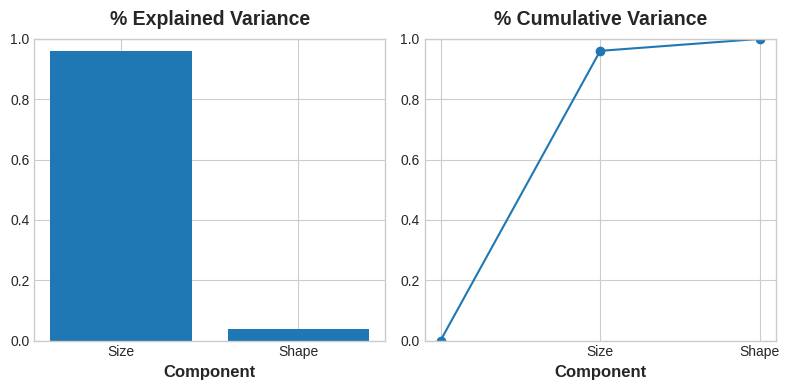

The `Size` component captures the majority of the variation between `Height` and `Diameter`. It's important to remember, however, that the amount of variance in a component doesn't necessarily correspond to how good it is as a predictor: it depends on what you're trying to predict.

### PCA for Feature Engineering

There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of `'Height'` and `'Diameter'` if `'Size'` is important, say, or a ratio of `'Height'` and `'Diameter'` if `Shape` is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:
- **Dimensionality reduction**: When your features are highly redundant (*multicollinear*, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- **Anomaly detection**: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- **Noise reduction**: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- **Decorrelation**: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

PCA basically gives you direct access to the correlational structure of your data. You'll no doubt come up with applications of your own!

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>PCA Best Practices</strong><br>
There are a few things to keep in mind when applying PCA:
<ul>
<li> PCA only works with numeric features, like continuous quantities or counts.
<li> PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
<li> Consider removing or constraining outliers, since they can have an undue influence on the results.
</ul>
</blockquote>

### Example: 1985 Automobiles

In this example, we'll return to our [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) dataset and apply PCA, using it as a descriptive technique to discover features. We'll look at other use-cases in the exercise.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv(f"{root_path}/data/autos.csv")

In [ ]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [ ]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


from matplotlib import pyplot as plt
loadings['PC1'].plot(kind='hist', bins=20, title='PC1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loadings['PC2'].plot(kind='hist', bins=20, title='PC2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loadings['PC3'].plot(kind='hist', bins=20, title='PC3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loadings['PC4'].plot(kind='hist', bins=20, title='PC4')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loadings.plot(kind='scatter', x='PC1', y='PC2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loadings.plot(kind='scatter', x='PC2', y='PC3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loadings.plot(kind='scatter', x='PC3', y='PC4', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
loadings['PC1'].plot(kind='line', figsize=(8, 4), title='PC1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
loadings['PC2'].plot(kind='line', figsize=(8, 4), title='PC2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
loadings['PC3'].plot(kind='line', figsize=(8, 4), title='PC3')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
loadings['PC4'].plot(kind='line', figsize=(8, 4), title='PC4')
plt.gca().spines[['top', 'right']].set_visible(False)

Example:

highway_mpg = 20

engine_size = 5

horsepower = 800

curb_weight = 5000

PC1 = -0.492347 * 20 + 0.503859 * 5 + 0.500448 * 800 + 0.503262 * 5000

Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

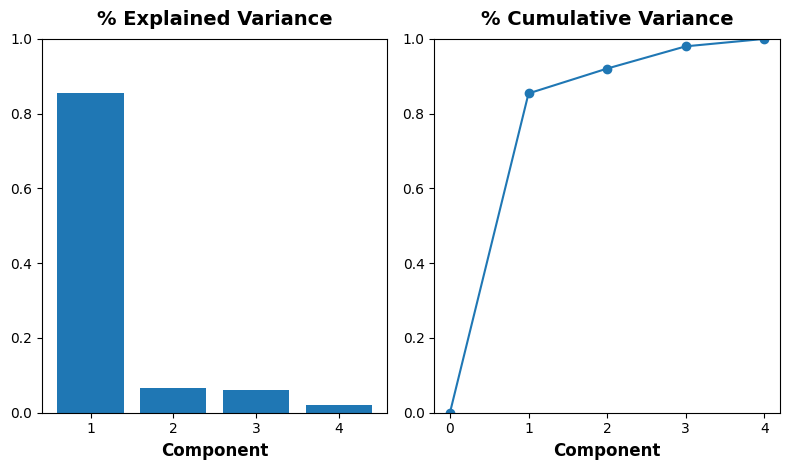

In [ ]:
# Look at explained variance
plot_variance(pca);

In [ ]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.012473
PC2    0.379076
PC3    0.306644
PC4    0.205197
Name: MI Scores, dtype: float64

## Creating New Features

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

accidents = pd.read_csv(f"{root_path}/data/accidents.csv")
autos = pd.read_csv(f"{root_path}/data/autos.csv")
concrete = pd.read_csv(f"{root_path}/data/concrete.csv")
customer = pd.read_csv(f"{root_path}/data/customer.csv")

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Tips on Discovering New Features</strong>
<ul>
<li>Understand the features. Refer to your dataset's <em>data documentation</em>, if available.
<li>Research the problem domain to acquire <strong>domain knowledge</strong>. If your problem is predicting house prices, do some research on real-estate for instance. Wikipedia can be a good starting point, but books and journal articles will often have the best information.
<li>Study previous work. <a href="https://www.kaggle.com/sudalairajkumar/winning-solutions-of-kaggle-competitions">Solution write-ups</a> from past Kaggle competitions are a great resource.
<li>Use data visualization. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that could be simplified. Be sure to visualize your dataset as you work through the feature engineering process.
<ul>
</blockquote>

### Ratios
In the Automobile dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [ ]:
autos["stroke_ratio"] = autos.stroke / autos.bore
autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn, like this formula for an engine's "displacement", a measure of its power:

In [ ]:
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)

Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of `WindSpeed` in *US Accidents* is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

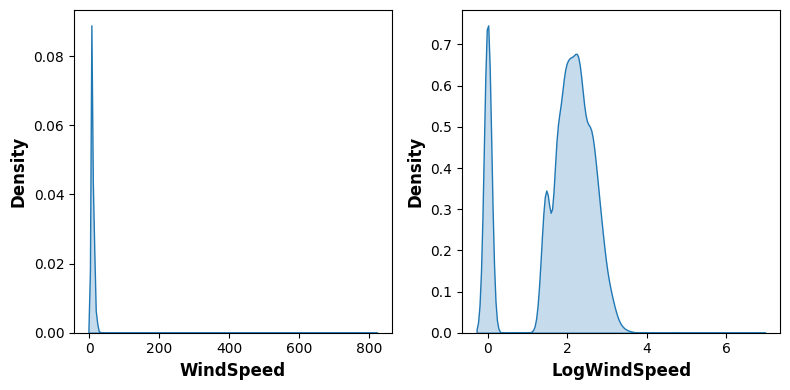

In [ ]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, fill=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, fill=True, ax=axs[1]);

### Counts
Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a count.

These features will be binary (1 for Present, 0 for Absent) or boolean (True or False). In Python, booleans can be added up just as if they were integers.

In Traffic Accidents are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the sum method:

In [ ]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


In the Concrete dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than gt method:

In [ ]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


### Groupping
Finally we have Group transforms, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that categry could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose State for the grouping feature, mean for the aggregation function, and Income for the aggregated feature. To compute this in Pandas, we use the groupby and transform methods:



In [ ]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


The mean function is a built-in dataframe method, which means we can pass it as a string to transform. Other handy methods include max, min, median, var, std, and count. Here's how you could calculate the frequency with which each state occurs in the dataset:

In [ ]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


In [ ]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Extended,482.077441
1,Premium,661.016570
2,Basic,376.210070
3,Basic,376.210070
4,Premium,661.016570
5,Basic,376.210070
6,Basic,376.210070
7,Basic,376.210070
8,Premium,661.016570
9,Basic,376.210070
